In [306]:
# Importa bibliotecas
from datetime import timedelta
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns  
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [307]:
# Usa pandas para ler o csv
df = pd.read_csv("D:\\Codigos\\Fatec\\lab4\\timeSeries\\base\\Weather Data.csv")
df.head()

# Dataset: https://www.kaggle.com/datasets/swatikhedekar/python-project-on-weather-dataset/
# OBS: para esse exercicio apenas o primerio mês está sendo usado

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [308]:
# Como essa será uma validação simples, usarei apenas Temp_C
df = df[['Date/Time', 'Temp_C']]
df.head()


,Date/Time,Temp_C
0,1/1/2012 0:00,-1.8
1,1/1/2012 1:00,-1.8
2,1/1/2012 2:00,-1.8
3,1/1/2012 3:00,-1.5
4,1/1/2012 4:00,-1.5


In [309]:
# ve quantidade de valores nulos, para tratamento
df.isnull().sum()


Date/Time    0
Temp_C       0
dtype: int64

In [310]:
# Preencheria colunas em branco, caso tivesse
df.interpolate(method='linear', inplace=True)

C:\Users\augus\AppData\Local\Temp\ipykernel_13536\300933832.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [311]:
# ve o tipo do dado, para tratamento
df.dtypes


Date/Time     object
Temp_C       float64
dtype: object

In [312]:
"""
A analise temporal geralmente preve tempo (datetime) por valor numerico (float ou int), nesse caso precisamos converter
a coluna Data/Time para datetime.
"""

df['Date/Time'] = pd.to_datetime(df['Date/Time'])
print(df.dtypes)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

# caso Temp_C não fosse int ou float usariamos pandas para sua conversão também.


Date/Time    datetime64[ns]
Temp_C              float64
dtype: object
+----+---------------------+----------+
|    | Date/Time           |   Temp_C |
|----+---------------------+----------|
|  0 | 2012-01-01 00:00:00 |     -1.8 |
|  1 | 2012-01-01 01:00:00 |     -1.8 |
|  2 | 2012-01-01 02:00:00 |     -1.8 |
|  3 | 2012-01-01 03:00:00 |     -1.5 |
|  4 | 2012-01-01 04:00:00 |     -1.5 |
+----+---------------------+----------+


In [313]:
# Definimos a coluna Date/Time como indice para melhor visualização
df.set_index('Date/Time', inplace=True)
df.sort_index(inplace=True)


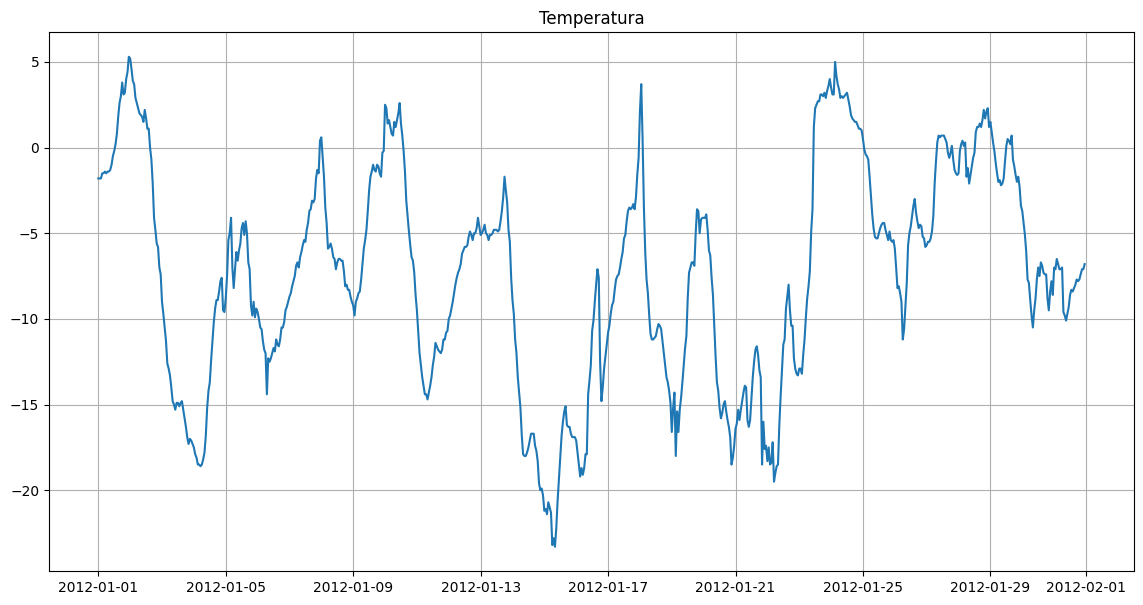

In [314]:
# Dataset completo
plt.figure(figsize=(14, 7))
plt.plot(df)
plt.title("Temperatura")
plt.grid(True)
plt.show()


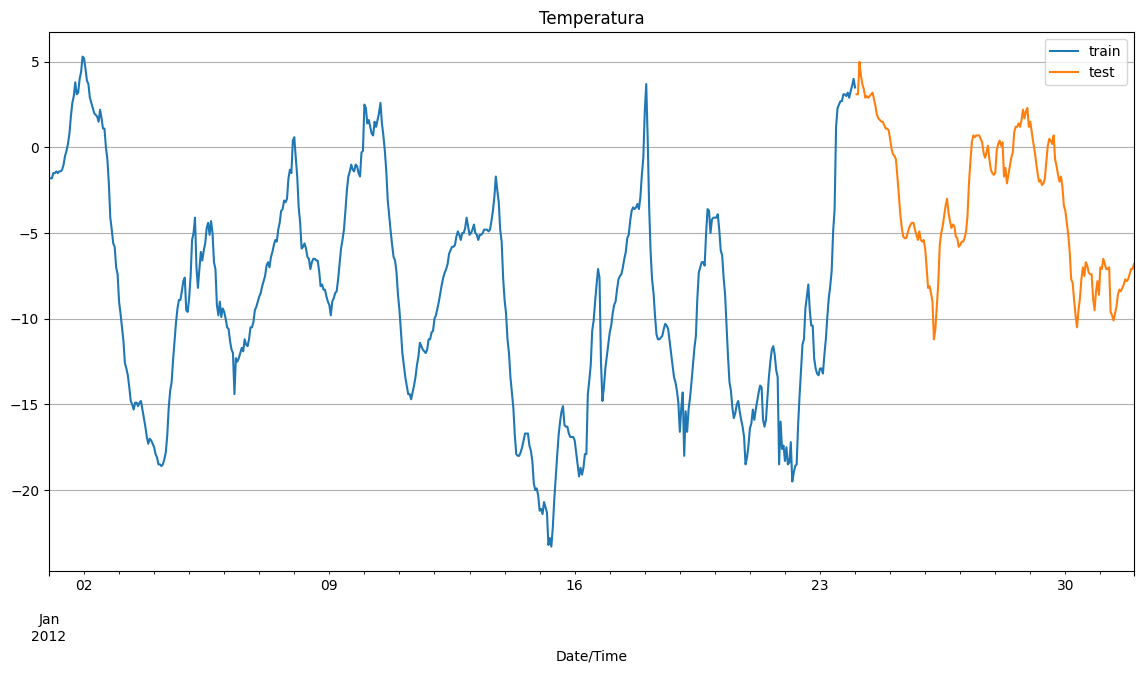

In [315]:
"""
Em nosso caso estamos visualizando temperatura de hora em hora durante janeiro 2012, vamos separar os ultimos 7 dias
para teste e o resto pro treino
"""
split_date = '2012-01-24 00:00:00'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

fig, ax=plt.subplots(figsize=(14, 7))
data_train['Temp_C'].plot(ax=ax, label='train')
data_test['Temp_C'].plot(ax=ax, label='test')
ax.legend();
plt.title("Temperatura")
plt.grid(True)
plt.show()


In [316]:
# Calcular pesos exponenciais decrescentes
max_date = data_train.index.max()
data_train['weight'] = np.exp((data_train.index - max_date) / timedelta(days=1))

# Normalizar pesos para somarem 1
data_train['weight'] = data_train['weight'] / data_train['weight'].sum()

In [317]:
# GridSearch para ajustar hiperparâmetros do RandomForest
param_grid = {
    'n_estimators': [7, 30, 365],
    'max_depth': [10, 15, 20, 25, 30]
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=123), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(data_train['Temp_C'].values.reshape(-1, 1), data_train['Temp_C'])
best_params = grid_search.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [318]:
# Função para criar lags
def create_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    return df_lags

# Cria lags para o conjunto de treinamento
lags = 506
train_lags = create_lags(data_train['Temp_C'], lags)
train_lags = train_lags.dropna()
weights = data_train['weight'][lags:]

C:\Users\augus\AppData\Local\Temp\ipykernel_13536\2053726366.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lags[f'lag_{lag}'] = data.shift(lag)
C:\Users\augus\AppData\Local\Temp\ipykernel_13536\2053726366.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lags[f'lag_{lag}'] = data.shift(lag)
C:\Users\augus\AppData\Local\Temp\ipykernel_13536\2053726366.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

d:\Codigos\Fatec\lab4\timeSeries\myVenv\Lib\site-packages\skforecast\utils\utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
d:\Codigos\Fatec\lab4\timeSeries\myVenv\Lib\site-packages\skforecast\utils\utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
d:\Codigos\Fatec\lab4\timeSeries\myVenv\Lib\site-packages\skforecast\utils\utils.py:1120: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


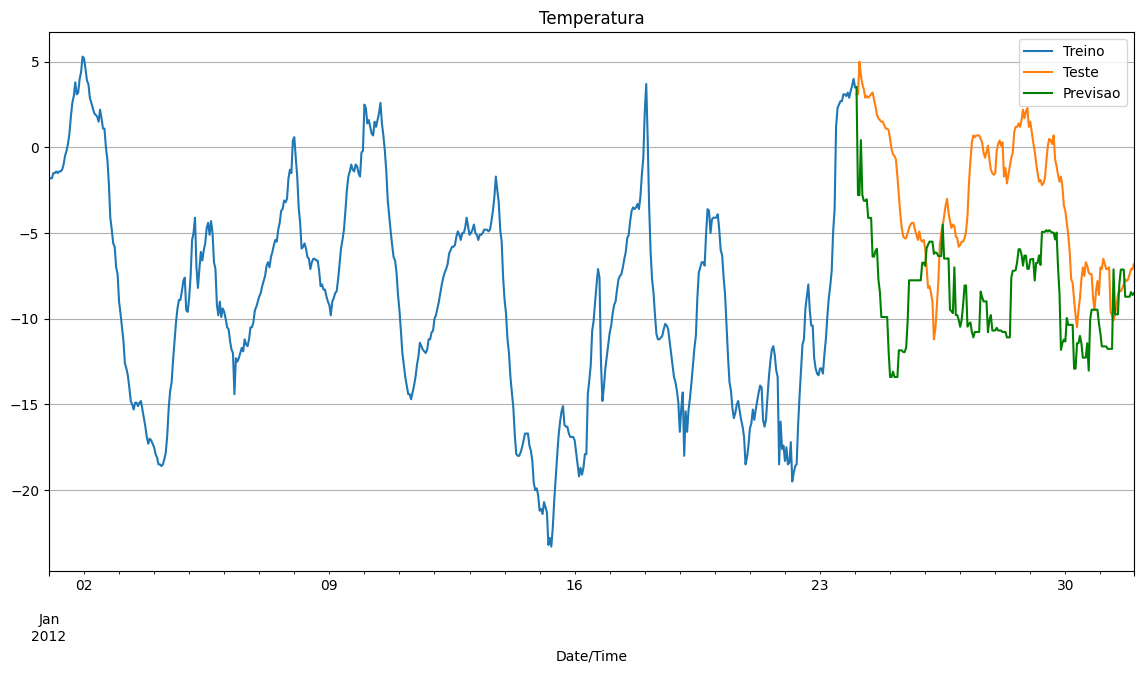

In [319]:
# Cria e treina o modelo
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(**best_params, random_state=123),
    lags=lags
)

forecaster.fit(y=data_train['Temp_C'])

# Faz previsões
predictions = forecaster.predict(steps=len(data_test))
predictions.index = data_test.index

# Visualização das previsões
fig, ax = plt.subplots(figsize=(14, 7))
data_train['Temp_C'].plot(ax=ax, label='Treino')
data_test['Temp_C'].plot(ax=ax, label='Teste')
predictions.index = data_test.index
predictions.plot(ax=ax, label='Previsao', color='green')
ax.legend()
plt.title("Temperatura")
plt.grid(True)
plt.show()



In [320]:
# Calcula e exibe métricas de avaliação
mse = mean_squared_error(data_test['Temp_C'], predictions)
mae = mean_absolute_error(data_test['Temp_C'], predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 45.27705737792499
Mean Absolute Error: 5.766791323859388
